### load packages

In [1]:
import sys
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
# data in .parquet format, method for loading requires pyarrow and fastparquet
#! pip install pyarrow fastparquet

### load data for month of choice
I created a loading file that directly loads the data files from the NYC TLC website. You can input month and year as either value types or string types. Here, we load only the `yellow` taxi data.

# Yellow Taxi

In [3]:
# load yellow taxi data for month 01/2023
df_y = pr.load_taxi_data(month = 1, year = 2023, vehicle_type = 'yellow')

In [4]:
df_y.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


### initial preprocessing
Each different dataset has different column names for the column corresponding to `pickup_datetime`. For the `yellow` taxis, it is `tpep_pickup_datetime`. Let's change the name to just `pickup_datetime`. 

In [5]:
# split datetime into data and time
df_y.rename(
    columns = {'tpep_pickup_datetime': 'pickup_datetime',
               'tpep_dropoff_datetime': 'dropoff_datetime'}, 
    inplace = True
)

Note, this dataset contains rides occurring in dates outside of Jan. 2023. This may be data missing from older datasets that were only added later. This is something worth checking when we combine multiple datasets. For now, we just restrict this dataset to have rides in Jan. 2023.

In [6]:
print(df_y.pickup_datetime.sort_values().head())
print('\n ')
print('Min: ' + str(df_y.pickup_datetime.sort_values().min()), ', Max: ' + str(df_y.pickup_datetime.sort_values().max()))

2138036   2008-12-31 23:01:42
209091    2008-12-31 23:04:41
10023     2022-10-24 17:37:47
18219     2022-10-24 20:01:46
21660     2022-10-24 21:45:35
Name: pickup_datetime, dtype: datetime64[us]

 
Min: 2008-12-31 23:01:42 , Max: 2023-02-01 00:56:53


In [7]:
# remove rows with year not equal to 2023 and within January
df_y = df_y[(df_y.pickup_datetime.dt.year == 2023) & (df_y.pickup_datetime.dt.month == 1)]
df_y.pickup_datetime.sort_values().head()

2995098   2023-01-01 00:00:00
3497      2023-01-01 00:00:05
2506      2023-01-01 00:00:06
3499      2023-01-01 00:00:08
4475      2023-01-01 00:00:09
Name: pickup_datetime, dtype: datetime64[us]

In [8]:
df_y.shape

(3066718, 19)

In [9]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3066718 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   pickup_datetime        datetime64[us]
 2   dropoff_datetime       datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

### binning the data
Each time step in our time series will correspond to quantities from the previous hour. E.g., we will define $y_t$ to be the number of rides occurring in a given taxi zone from time $y_{t-1}$ to $y_{t}$, where $t$ is measured in hours.

For number of rides, this can be done in one line. 

/tmp/ipykernel_730/1262603394.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


pickup_datetime
2023-01-01 00:00:00    5336
2023-01-01 01:00:00    5752
2023-01-01 02:00:00    5097
2023-01-01 03:00:00    3952
2023-01-01 04:00:00    2501
Freq: h, dtype: int64


(464592.0, 464808.0)

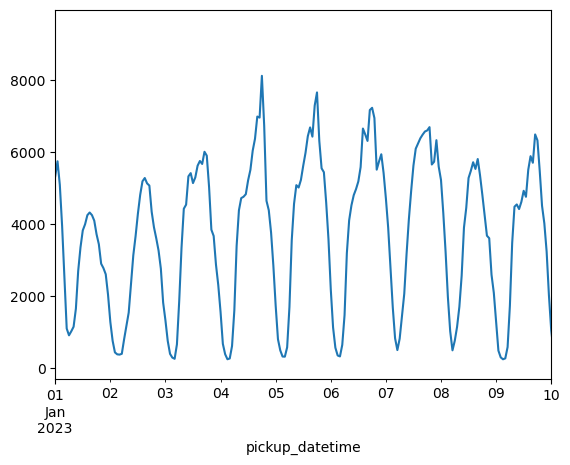

In [10]:
# convert to hourly time series
ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_y.head())

# plot hourly time series
ts_y.plot()
plt.xlim('2023-01-01', '2023-01-10')

/tmp/ipykernel_730/2737972791.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


pickup_datetime
2023-01-01 00:00:00    5336
2023-01-01 01:00:00    5752
2023-01-01 02:00:00    5097
2023-01-01 03:00:00    3952
2023-01-01 04:00:00    2501
Freq: h, dtype: int64


(464592.0, 464616.0)

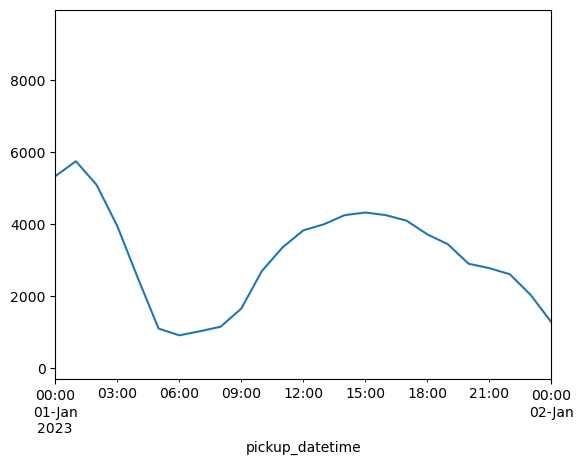

In [11]:
ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_y.head())

# plot hourly time series
ts_y.plot()
plt.xlim('2023-01-01', '2023-01-2')

/tmp/ipykernel_730/1960816021.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


pickup_datetime
2023-01-01 00:00:00    5336
2023-01-01 01:00:00    5752
2023-01-01 02:00:00    5097
2023-01-01 03:00:00    3952
2023-01-01 04:00:00    2501
Freq: h, dtype: int64


(464616.0, 464640.0)

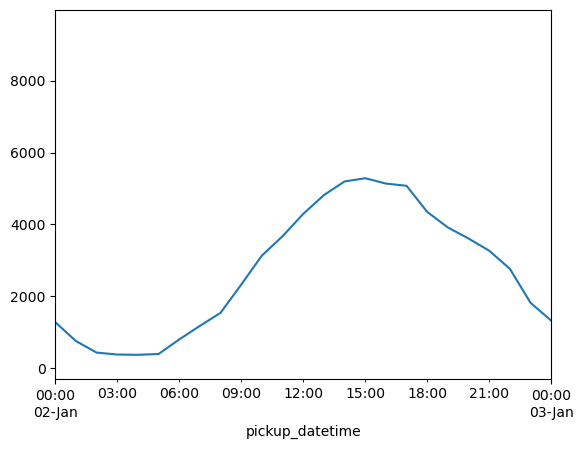

In [12]:
ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_y.head())

# plot hourly time series
ts_y.plot()
plt.xlim('2023-01-02', '2023-01-03')

### This is Friday graph

/tmp/ipykernel_730/547637738.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


pickup_datetime
2023-01-01 00:00:00    5336
2023-01-01 01:00:00    5752
2023-01-01 02:00:00    5097
2023-01-01 03:00:00    3952
2023-01-01 04:00:00    2501
Freq: h, dtype: int64


(464712.0, 464736.0)

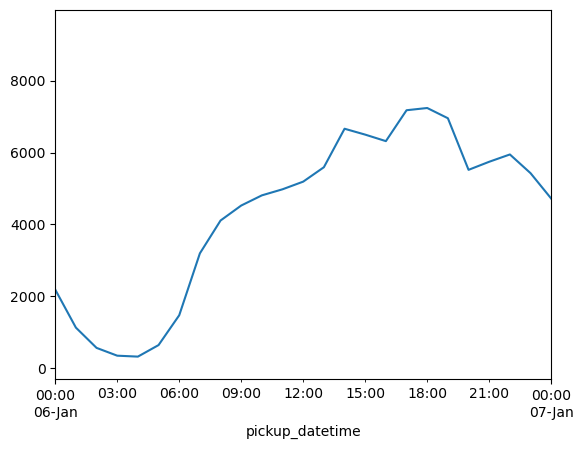

In [13]:
ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_y.head())

# plot hourly time series
ts_y.plot()
plt.xlim('2023-01-06', '2023-01-07')

### Same behavior goes for Sat 

/tmp/ipykernel_730/3253522611.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


pickup_datetime
2023-01-01 00:00:00    5336
2023-01-01 01:00:00    5752
2023-01-01 02:00:00    5097
2023-01-01 03:00:00    3952
2023-01-01 04:00:00    2501
Freq: h, dtype: int64


(464736.0, 464760.0)

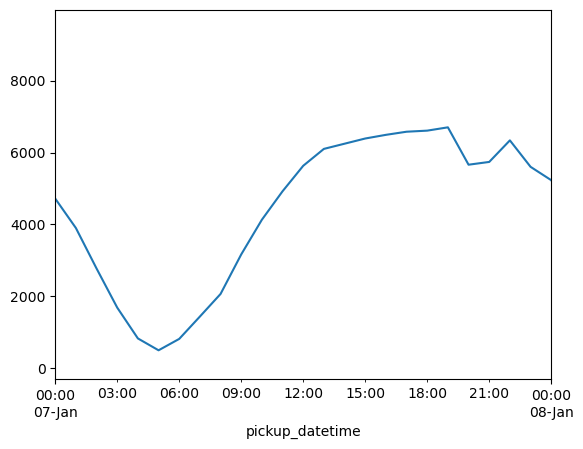

In [14]:
ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_y.head())

# plot hourly time series
ts_y.plot()
plt.xlim('2023-01-07', '2023-01-08')

### Sunday graph

/tmp/ipykernel_730/3417362762.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


pickup_datetime
2023-01-01 00:00:00    5336
2023-01-01 01:00:00    5752
2023-01-01 02:00:00    5097
2023-01-01 03:00:00    3952
2023-01-01 04:00:00    2501
Freq: h, dtype: int64


(464760.0, 464784.0)

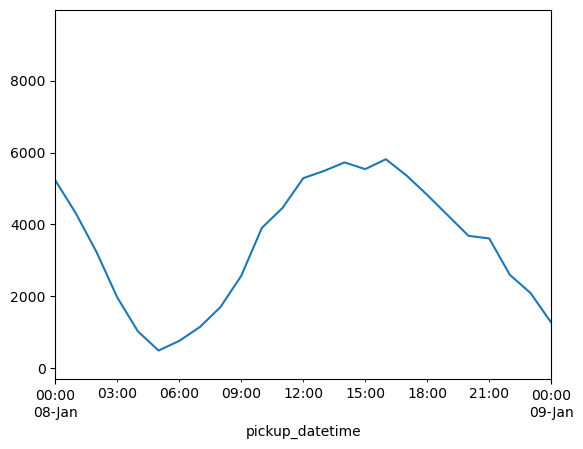

In [15]:
ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_y.head())

# plot hourly time series
ts_y.plot()
plt.xlim('2023-01-08', '2023-01-09')

pickup_datetime
2023-01-01     76752
2023-01-02     65777
2023-01-03     85783
2023-01-04     95092
2023-01-05    101063
Freq: D, dtype: int64


(19358.0, 19366.0)

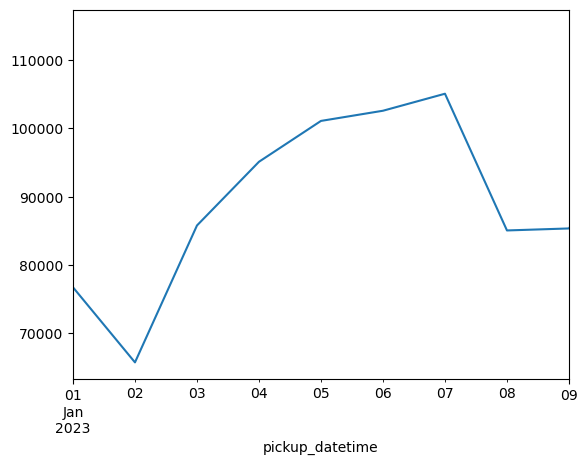

In [16]:
ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='D')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_y.head())

# plot hourly time series
ts_y.plot()
plt.xlim('2023-01-01', '2023-01-09')

In [17]:
ts_h_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='h')).size()

In [18]:
type(ts_h_y)

pandas.core.series.Series

In [19]:
ts_h_y.head()

pickup_datetime
2023-01-01 00:00:00    5336
2023-01-01 01:00:00    5752
2023-01-01 02:00:00    5097
2023-01-01 03:00:00    3952
2023-01-01 04:00:00    2501
Freq: h, dtype: int64

In [20]:
ts_H_y= ts_h_y.to_frame(name = 'counts')

In [21]:
type(ts_H_y)

pandas.core.frame.DataFrame

In [22]:
ts_H_y.head()

,counts
pickup_datetime,
2023-01-01 00:00:00,5336
2023-01-01 01:00:00,5752
2023-01-01 02:00:00,5097
2023-01-01 03:00:00,3952
2023-01-01 04:00:00,2501


In [23]:
ts_H_y['hour'] = ts_H_y.index.hour

In [24]:
ts_H_y

,counts,hour
pickup_datetime,,
2023-01-01 00:00:00,5336,0
2023-01-01 01:00:00,5752,1
2023-01-01 02:00:00,5097,2
2023-01-01 03:00:00,3952,3
2023-01-01 04:00:00,2501,4
...,...,...
2023-01-31 19:00:00,6586,19
2023-01-31 20:00:00,6163,20
2023-01-31 21:00:00,6223,21


In [25]:
ts_H_y['day_of_week'] = ts_H_y.index.day_name()

In [26]:
ts_H_y.head()

,counts,hour,day_of_week
pickup_datetime,,,
2023-01-01 00:00:00,5336,0,Sunday
2023-01-01 01:00:00,5752,1,Sunday
2023-01-01 02:00:00,5097,2,Sunday
2023-01-01 03:00:00,3952,3,Sunday
2023-01-01 04:00:00,2501,4,Sunday


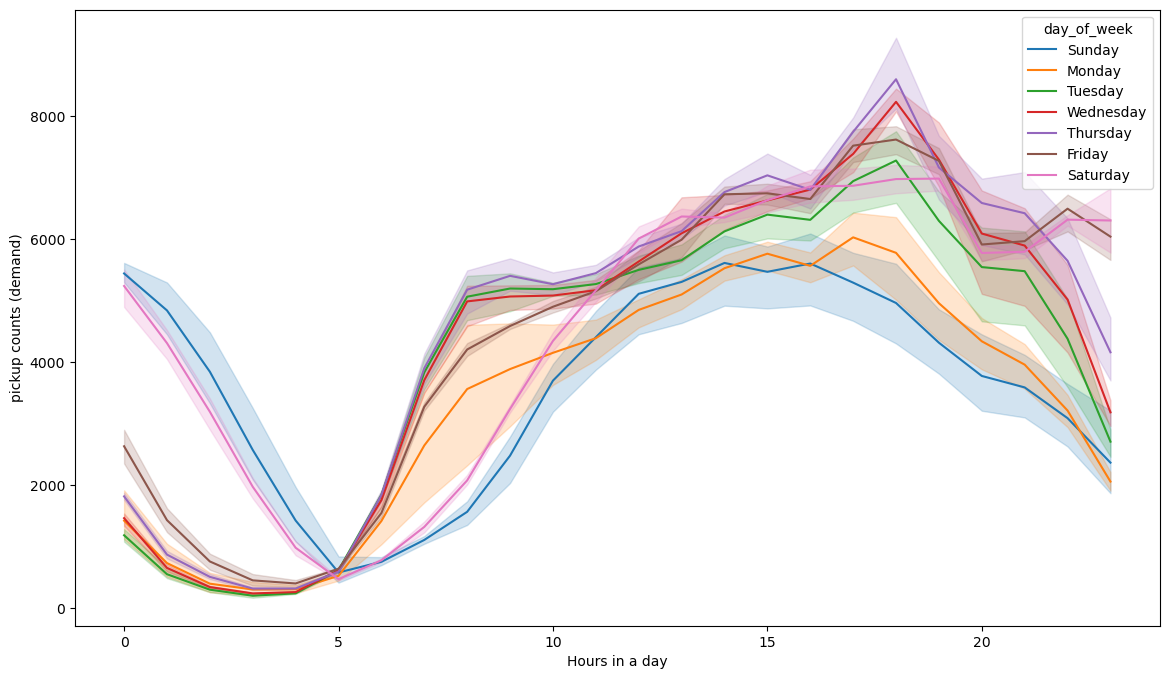

In [27]:
plt.figure(figsize = (14,8))
sns.lineplot(data = ts_H_y, x = ts_H_y['hour'] , y = ts_H_y['counts'], hue = 'day_of_week')
#plt.xlim('2023-01-01', '2023-01-08')
#plt.xticks(ts_H['hour'])
plt.xlabel('Hours in a day')
plt.ylabel('pickup counts (demand)')
plt.show()

# Green Taxi 

In [28]:
df_g = pr.load_taxi_data(month = 1, year = 2023, vehicle_type = 'green')
df_g.head()


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00


### initial preprocessing
Each different dataset has different column names for the column corresponding to `pickup_datetime`. For the `green` taxis, it is `lpep_pickup_datetime`. Let's change the name to just `pickup_datetime`. 

In [29]:
df_g.rename(
    columns = {'lpep_pickup_datetime': 'pickup_datetime',
               'lpep_dropoff_datetime': 'dropoff_datetime'}, 
    inplace = True
)
print(df_g.pickup_datetime.sort_values().head())
print('\n ')
print('Min: ' + str(df_g.pickup_datetime.sort_values().min()), ', Max: ' + str(df_g.pickup_datetime.sort_values().max()))


17874   2009-01-01 20:21:27
298     2022-12-09 14:10:49
318     2022-12-09 14:55:42
24      2023-01-01 00:01:31
44      2023-01-01 00:04:25
Name: pickup_datetime, dtype: datetime64[us]

 
Min: 2009-01-01 20:21:27 , Max: 2023-02-01 03:10:05


In [30]:
# remove rows with year not equal to 2023 and within January
df_g = df_g[(df_g.pickup_datetime.dt.year == 2023) & (df_g.pickup_datetime.dt.month == 1)]
df_g.pickup_datetime.sort_values().head()

24   2023-01-01 00:01:31
44   2023-01-01 00:04:25
57   2023-01-01 00:06:48
41   2023-01-01 00:08:05
11   2023-01-01 00:08:43
Name: pickup_datetime, dtype: datetime64[us]

In [31]:
# Green taxi is a much smaller data set 
df_g.shape

(68207, 20)

In [32]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68207 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               68207 non-null  int64         
 1   pickup_datetime        68207 non-null  datetime64[us]
 2   dropoff_datetime       68207 non-null  datetime64[us]
 3   store_and_fwd_flag     63883 non-null  object        
 4   RatecodeID             63883 non-null  float64       
 5   PULocationID           68207 non-null  int64         
 6   DOLocationID           68207 non-null  int64         
 7   passenger_count        63883 non-null  float64       
 8   trip_distance          68207 non-null  float64       
 9   fare_amount            68207 non-null  float64       
 10  extra                  68207 non-null  float64       
 11  mta_tax                68207 non-null  float64       
 12  tip_amount             68207 non-null  float64       
 13  tolls_

## same visualization as we had for the yellow taxis 

pickup_datetime
2023-01-01 00:00:00    84
2023-01-01 01:00:00    87
2023-01-01 02:00:00    85
2023-01-01 03:00:00    70
2023-01-01 04:00:00    33
Freq: h, dtype: int64


/tmp/ipykernel_730/3914264977.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


(464592.0, 464808.0)

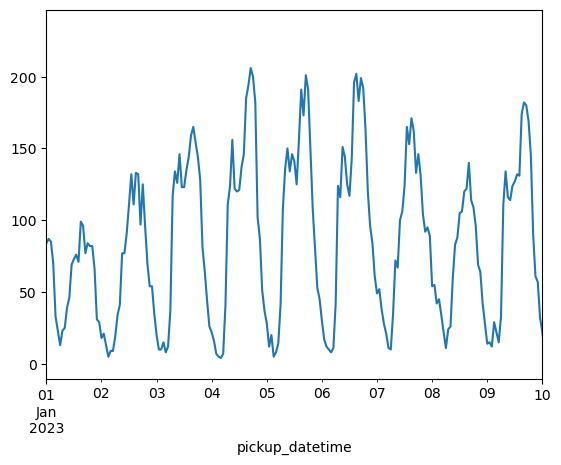

In [33]:
# convert to hourly time series
ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_g.head())

# plot hourly time series
ts_g.plot()
plt.xlim('2023-01-01', '2023-01-10')

pickup_datetime
2023-01-01 00:00:00    84
2023-01-01 01:00:00    87
2023-01-01 02:00:00    85
2023-01-01 03:00:00    70
2023-01-01 04:00:00    33
Freq: h, dtype: int64


/tmp/ipykernel_730/3182982656.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


(464592.0, 464616.0)

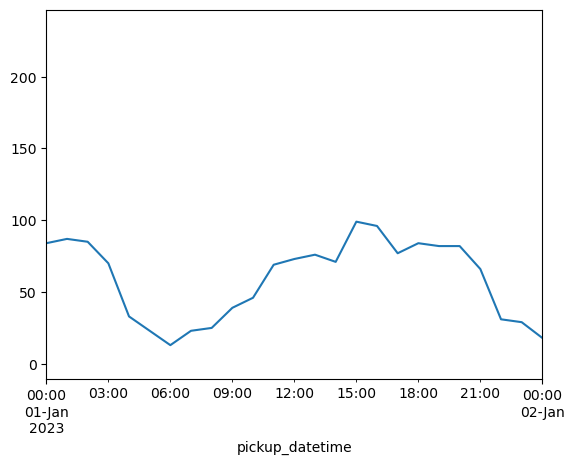

In [34]:
ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_g.head())

# plot hourly time series
ts_g.plot()
plt.xlim('2023-01-01', '2023-01-02')

pickup_datetime
2023-01-01 00:00:00    84
2023-01-01 01:00:00    87
2023-01-01 02:00:00    85
2023-01-01 03:00:00    70
2023-01-01 04:00:00    33
Freq: h, dtype: int64


/tmp/ipykernel_730/238745505.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


(464616.0, 464640.0)

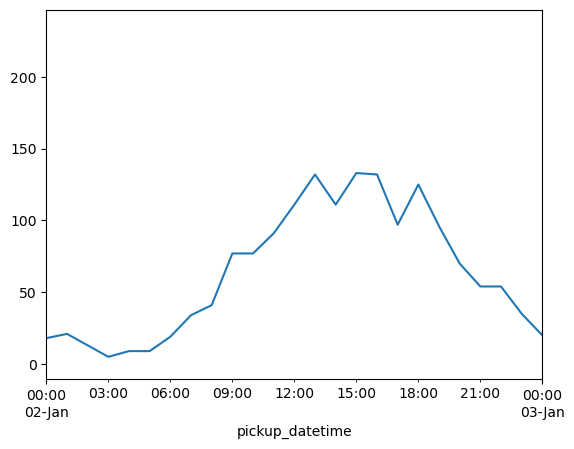

In [35]:
ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_g.head())

# plot hourly time series
ts_g.plot()
plt.xlim('2023-01-02', '2023-01-03')

pickup_datetime
2023-01-01 00:00:00    84
2023-01-01 01:00:00    87
2023-01-01 02:00:00    85
2023-01-01 03:00:00    70
2023-01-01 04:00:00    33
Freq: h, dtype: int64


/tmp/ipykernel_730/435847598.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


(464640.0, 464664.0)

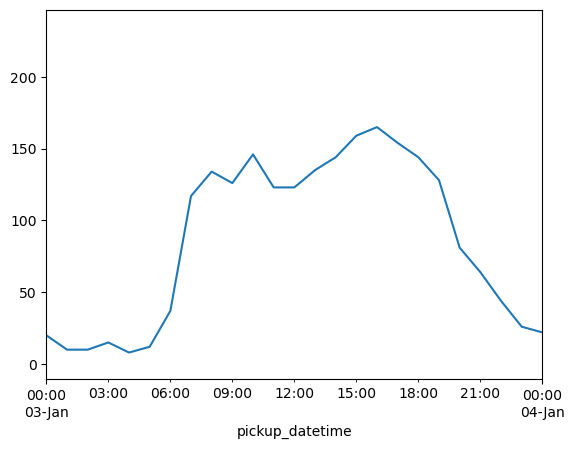

In [36]:
ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_g.head())

# plot hourly time series
ts_g.plot()
plt.xlim('2023-01-03', '2023-01-04')

pickup_datetime
2023-01-01 00:00:00    84
2023-01-01 01:00:00    87
2023-01-01 02:00:00    85
2023-01-01 03:00:00    70
2023-01-01 04:00:00    33
Freq: h, dtype: int64


/tmp/ipykernel_730/357619335.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


(464664.0, 464688.0)

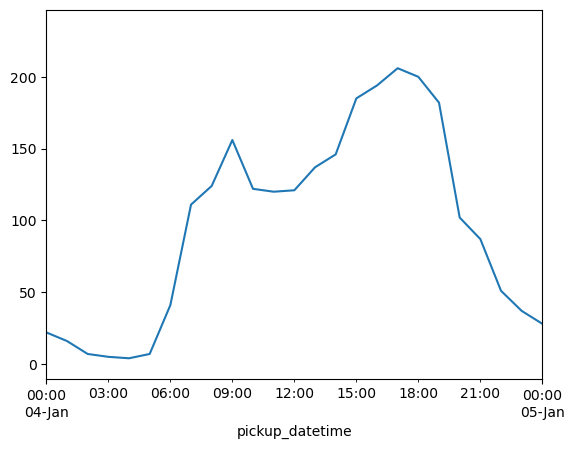

In [37]:
ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_g.head())

# plot hourly time series
ts_g.plot()
plt.xlim('2023-01-04', '2023-01-05')

pickup_datetime
2023-01-01 00:00:00    84
2023-01-01 01:00:00    87
2023-01-01 02:00:00    85
2023-01-01 03:00:00    70
2023-01-01 04:00:00    33
Freq: h, dtype: int64


/tmp/ipykernel_730/257085034.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


(464688.0, 464712.0)

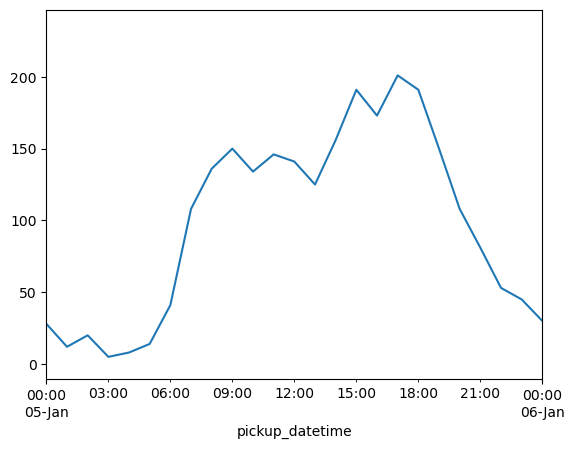

In [38]:
ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_g.head())

# plot hourly time series
ts_g.plot()
plt.xlim('2023-01-05', '2023-01-06')

pickup_datetime
2023-01-01 00:00:00    84
2023-01-01 01:00:00    87
2023-01-01 02:00:00    85
2023-01-01 03:00:00    70
2023-01-01 04:00:00    33
Freq: h, dtype: int64


/tmp/ipykernel_730/4285395704.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


(464712.0, 464736.0)

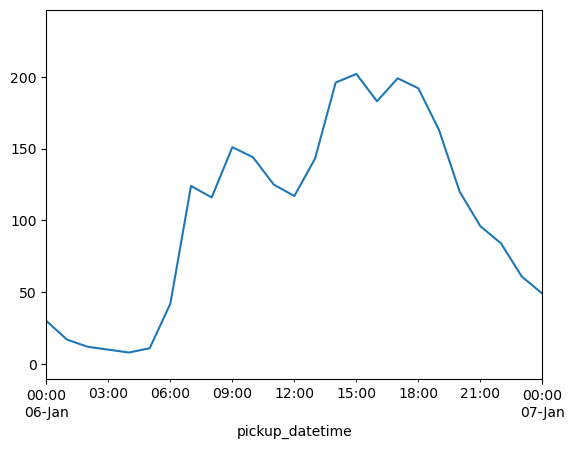

In [39]:
ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_g.head())

# plot hourly time series
ts_g.plot()
plt.xlim('2023-01-06', '2023-01-07')

pickup_datetime
2023-01-01 00:00:00    84
2023-01-01 01:00:00    87
2023-01-01 02:00:00    85
2023-01-01 03:00:00    70
2023-01-01 04:00:00    33
Freq: h, dtype: int64


/tmp/ipykernel_730/333720475.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


(464736.0, 464760.0)

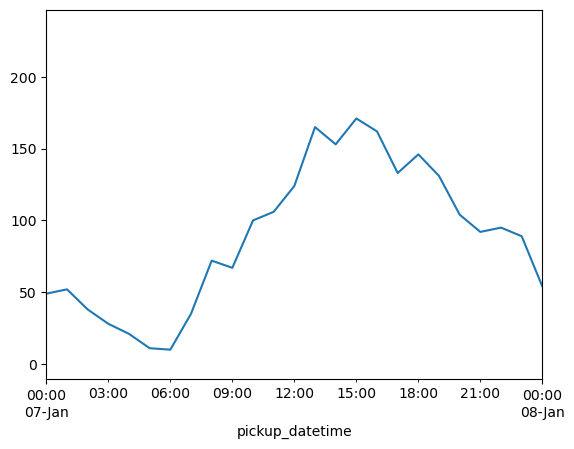

In [40]:
ts_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_g.head())

# plot hourly time series
ts_g.plot()
plt.xlim('2023-01-07', '2023-01-08')

In [41]:
ts_h_g = df_g.set_index('pickup_datetime').groupby(pd.Grouper(freq='h')).size()


In [42]:
type(ts_h_g)


pandas.core.series.Series

In [43]:
ts_h_g.head()

pickup_datetime
2023-01-01 00:00:00    84
2023-01-01 01:00:00    87
2023-01-01 02:00:00    85
2023-01-01 03:00:00    70
2023-01-01 04:00:00    33
Freq: h, dtype: int64

In [44]:
ts_H_g= ts_h_g.to_frame(name = 'counts')

In [45]:
type(ts_H_g)


pandas.core.frame.DataFrame

In [46]:
ts_H_g['hour'] = ts_H_g.index.hour


In [47]:
# same number of rows for the month of Jan of 2023 but much less demand 
ts_H_g  

,counts,hour
pickup_datetime,,
2023-01-01 00:00:00,84,0
2023-01-01 01:00:00,87,1
2023-01-01 02:00:00,85,2
2023-01-01 03:00:00,70,3
2023-01-01 04:00:00,33,4
...,...,...
2023-01-31 19:00:00,149,19
2023-01-31 20:00:00,122,20
2023-01-31 21:00:00,87,21


In [48]:
ts_H_g['day_of_week'] = ts_H_g.index.day_name()

In [49]:
ts_H_g.head()

,counts,hour,day_of_week
pickup_datetime,,,
2023-01-01 00:00:00,84,0,Sunday
2023-01-01 01:00:00,87,1,Sunday
2023-01-01 02:00:00,85,2,Sunday
2023-01-01 03:00:00,70,3,Sunday
2023-01-01 04:00:00,33,4,Sunday


### Let's look at the demand graph per day of the week

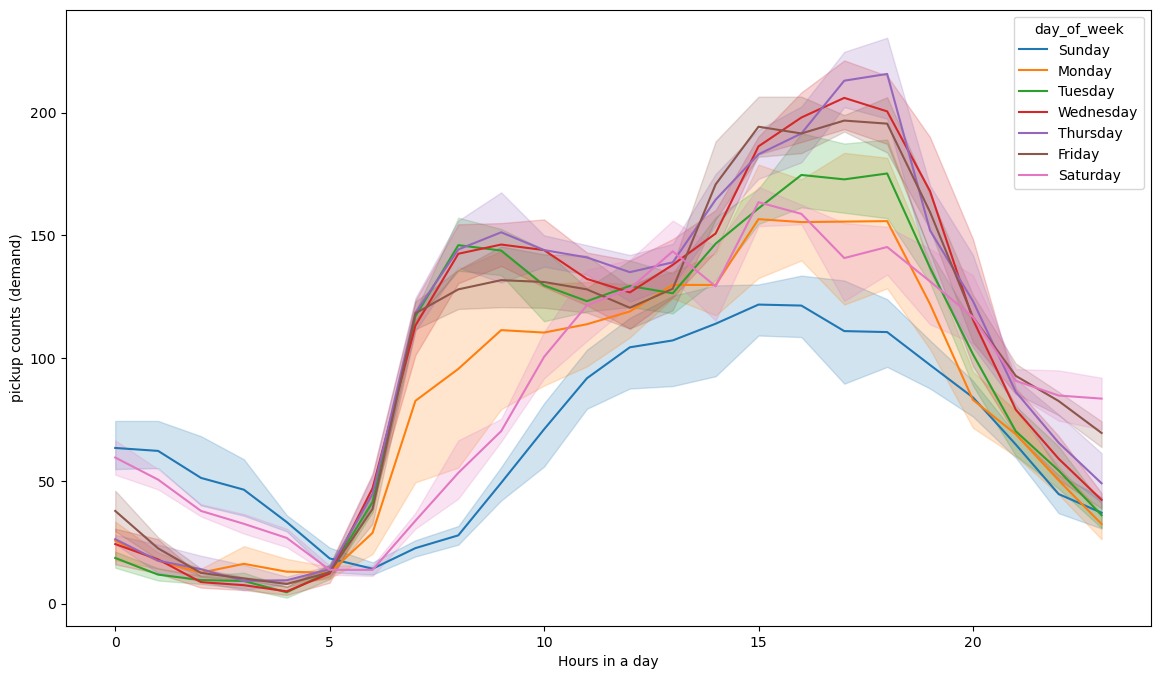

In [50]:
plt.figure(figsize = (14,8))
sns.lineplot(data = ts_H_g, x = ts_H_g['hour'] , y = ts_H_g['counts'], hue = 'day_of_week')
#plt.xlim('2023-01-01', '2023-01-08')
#plt.xticks(ts_H['hour'])
plt.xlabel('Hours in a day')
plt.ylabel('pickup counts (demand)')
plt.show()

In [51]:
# Green taxi demand vs Yellow taxi demand ratio in percent 
68207/3066718 * 100

2.224104074779618

## Comparison between the Yellow and the Green taxi 

+ Yellow Taxis pick up street-hailing passengers anywhere in NYC. Green Taxis pick up street-hailing passengers in NYC except for below East 96th Street and West 110th Street in Manhattan.
You can book trips for both yellow and green taxis through an e-hail app or by calling car service companies. 
+ Although Green taxi is only 2.22% of the Yellow taxi demand, the hourly behavior of both are identical every day of the week as per the visualizations 

# For-Hire Vehicle 

In [52]:
df_fhv = pr.load_taxi_data(month = 1, year = 2023, vehicle_type = 'fhv')

In [53]:
df_fhv.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00008,2023-01-01 00:30:00,2023-01-01 01:00:00,NaN,NaN,None,B00008
1,B00078,2023-01-01 00:01:00,2023-01-01 03:15:00,NaN,NaN,None,B00078
2,B00111,2023-01-01 00:30:00,2023-01-01 01:05:00,NaN,NaN,None,B03406
3,B00112,2023-01-01 00:34:45,2023-01-01 00:52:03,NaN,14.0,None,B00112
4,B00112,2023-01-01 00:11:20,2023-01-01 00:22:03,NaN,14.0,None,B00112


In [54]:
df_fhv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114320 entries, 0 to 1114319
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1114320 non-null  object        
 1   pickup_datetime         1114320 non-null  datetime64[us]
 2   dropOff_datetime        1114320 non-null  datetime64[us]
 3   PUlocationID            234892 non-null   float64       
 4   DOlocationID            935715 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1114320 non-null  object        
dtypes: datetime64[us](2), float64(2), object(3)
memory usage: 59.5+ MB


In [55]:
# 80% of the rows of PUlocationID are nulls 
234892/1114320

0.2107940268504559

### initial preprocessing

In [56]:
# there are no wrongly entered data in regards to timestamp
df_fhv.rename(
    columns = {'dropOff_datetime': 'dropoff_datetime'}, 
    inplace = True
)
print(df_fhv.pickup_datetime.sort_values().head())
print('\n ')
print('Min: ' + str(df_fhv.pickup_datetime.sort_values().min()), ', Max: ' + str(df_fhv.pickup_datetime.sort_values().max()))


336   2023-01-01 00:00:00
756   2023-01-01 00:00:08
170   2023-01-01 00:00:13
348   2023-01-01 00:00:16
20    2023-01-01 00:00:20
Name: pickup_datetime, dtype: datetime64[us]

 
Min: 2023-01-01 00:00:00 , Max: 2023-01-31 23:59:50


/tmp/ipykernel_730/1518367856.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_fhv = df_fhv.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


pickup_datetime
2023-01-01 00:00:00    858
2023-01-01 01:00:00    785
2023-01-01 02:00:00    687
2023-01-01 03:00:00    589
2023-01-01 04:00:00    502
Freq: h, dtype: int64


(464592.0, 464808.0)

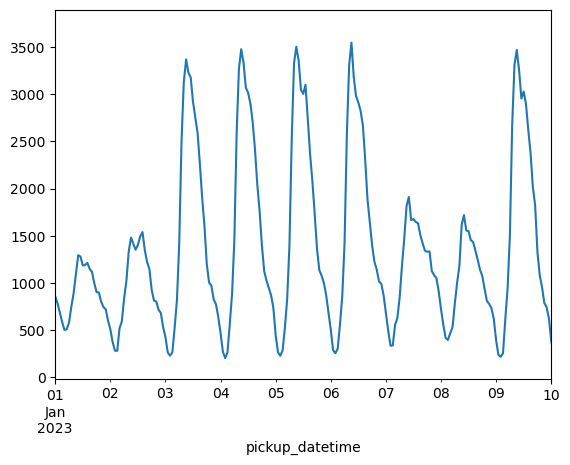

In [57]:
df_fhv = df_fhv.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(df_fhv.head())

# plot hourly time series
df_fhv.plot()
plt.xlim('2023-01-01', '2023-01-10')

In [58]:
df_fhv= df_fhv.to_frame(name = 'counts')

In [59]:
type(df_fhv)

pandas.core.frame.DataFrame

In [60]:
df_fhv['hour'] = df_fhv.index.hour


In [61]:
df_fhv

,counts,hour
pickup_datetime,,
2023-01-01 00:00:00,858,0
2023-01-01 01:00:00,785,1
2023-01-01 02:00:00,687,2
2023-01-01 03:00:00,589,3
2023-01-01 04:00:00,502,4
...,...,...
2023-01-31 19:00:00,1185,19
2023-01-31 20:00:00,1137,20
2023-01-31 21:00:00,1042,21


In [62]:
df_fhv['day_of_week'] = df_fhv.index.day_name()


In [63]:
df_fhv.head()

,counts,hour,day_of_week
pickup_datetime,,,
2023-01-01 00:00:00,858,0,Sunday
2023-01-01 01:00:00,785,1,Sunday
2023-01-01 02:00:00,687,2,Sunday
2023-01-01 03:00:00,589,3,Sunday
2023-01-01 04:00:00,502,4,Sunday


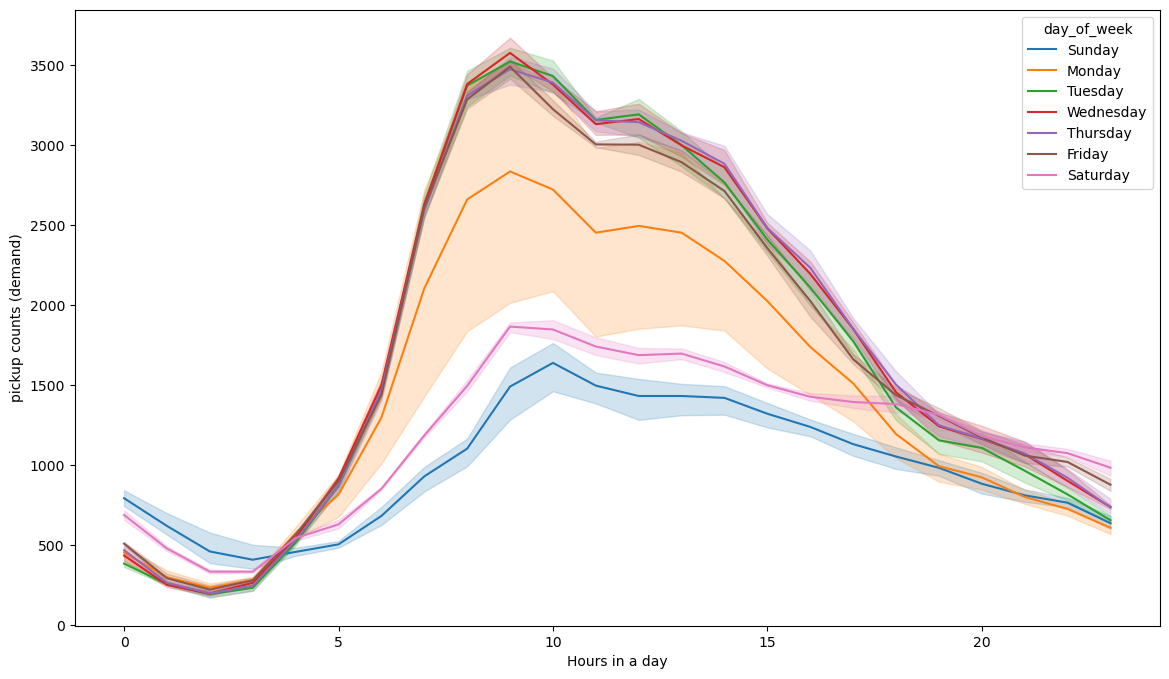

In [64]:
# plotting the hourly demand for each day of the week
plt.figure(figsize = (14,8))
sns.lineplot(data = df_fhv, x = df_fhv['hour'] , y = df_fhv['counts'], hue = 'day_of_week')
#plt.xlim('2023-01-01', '2023-01-08')
#plt.xticks(ts_H['hour'])
plt.xlabel('Hours in a day')
plt.ylabel('pickup counts (demand)')
plt.show() 

In [68]:
df_y

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


In [87]:
print(df_y[['fare_amount', 'extra', 'mta_tax', 'tip_amount']].isnull().values.sum())

71743


In [93]:
# print number of rows with nan by column
for col in df_y.columns:
    print(col + ': ' + str(df_y[col].isnull().values.sum()))

71743 / len(df_y)

VendorID: 0
pickup_datetime: 0
dropoff_datetime: 0
passenger_count: 71743
trip_distance: 0
RatecodeID: 71743
store_and_fwd_flag: 71743
PULocationID: 0
DOLocationID: 0
payment_type: 0
fare_amount: 0
extra: 0
mta_tax: 0
tip_amount: 0
tolls_amount: 0
improvement_surcharge: 0
total_amount: 0
congestion_surcharge: 71743
airport_fee: 71743


0.023394064925434943

In [75]:
len(df_y[df_y['passenger_count'] == 0.0]) / len(df_y)

0.016683633773956392

In [98]:
df_y_null = df_y[df_y.isnull().any(axis=1)]
for col in df_y_null.columns:
    print(col + ': ' + str(df_y_null[col].isnull().values.sum()))

VendorID: 0
pickup_datetime: 0
dropoff_datetime: 0
passenger_count: 71743
trip_distance: 0
RatecodeID: 71743
store_and_fwd_flag: 71743
PULocationID: 0
DOLocationID: 0
payment_type: 0
fare_amount: 0
extra: 0
mta_tax: 0
tip_amount: 0
tolls_amount: 0
improvement_surcharge: 0
total_amount: 0
congestion_surcharge: 71743
airport_fee: 71743


In [79]:
df_y[df_y['passenger_count'] == 0.0].groupby('store_and_fwd_flag').size()   

store_and_fwd_flag
N    49947
Y     1217
dtype: int64

In [80]:
df_y.groupby('store_and_fwd_flag').size()

store_and_fwd_flag
N    2974972
Y      20003
dtype: int64

### time series for most active taxi zone

In [65]:
print(df['PULocationID'].value_counts().head())
df_132 = df[df['PULocationID'] == 132]

NameError: name 'df' is not defined

In [ ]:
# convert to hourly time series
ts = df_132.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size()
ts.head()

# plot hourly time series
ts.plot()
plt.xlim('2023-01-01', '2023-01-10')

: 

: 